# Algorithmic Trading with TWAP and VWAP using Alpaca!

## Introduction

Among all technical indicators, one of the most popular and widely recognized are the volume-weighted average price and the time-weighted average price. They’re used to identify trends, potential support and resistance levels, as well as to gauge investment performance.

In this article, we’ll dive into how to calculate these indicators and how to create a simple algorithmic trading bot that makes buy and sell decisions based on the VWAP. 

### Download Dependencies

First, we must pip install (download) all the required dependencies for the program. In this case, the only required dependency that does not come pre-installed is alpaca-py. 

In [ ]:
%%capture
!pip install alpaca-py

### Import Dependencies

From within alpaca-py, we’ll need to import methods to access historical crypto data, live crypto data, and paper trading account access. We’ll also need matplotlib in order to plot graphs of the VWAP and TWAP and their relation to the Bitcoin Price.

In [ ]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data import CryptoDataStream
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
import matplotlib.pyplot as plt

### Define Variables

The next step is to define most of the general variables we’ll be needing throughout the program. For the API and Secret keys, you can access those on the main dashboard of your paper trading account overview.

For the trading strategy, we’ll be buying and selling Bitcoin, and each transaction will consist of 1 quantity.

In [ ]:
# API Credentials
API_KEY = '********************'
SECRET_KEY = '****************************************'
trading_client = TradingClient(API_KEY, SECRET_KEY, paper=True)

# Define variables
symbol = 'BTCUSD'
qty_per_trade = 1
start_date = "2022-08-08"

### Create Function to Check Account Positions

Next, we have to create a function to check whether the trading account currently holds any Bitcoin. If it does, we can return a 1 indicating true. If there is no Bitcoin, then the function will just return 0.

This is important because, in an upcoming function which handles the buying and selling, we can focus on buying only if there is currently no Bitcoin in the account. Otherwise, we’ll monitor the sell signal to see if the position should be closed.

In [ ]:
# Check Whether Account Currently Holds Symbol
def check_positions(symbol):
    positions = trading_client.get_all_positions()
    if symbol in str(positions):
        return 1
    return 0

### Retrieve Historical Bitcoin Price Data

Using alpaca-py’s cryptocurrency historical data client, we can send a request to get hourly data for Bitcoin from the start date specified earlier. In order to manipulate the data further, we can turn the resulting bars data into a dataframe.

In [ ]:
# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
                        symbol_or_symbols=["BTC/USD"],
                        timeframe=TimeFrame.Hour,
                        start=start_date
                 )

bars = client.get_crypto_bars(request_params)
df = bars.df
df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2022-08-08 00:00:00+00:00  23180.0  23344.0  23162.0  23261.0   
        2022-08-08 01:00:00+00:00  23273.0  23273.0  23173.0  23220.0   
        2022-08-08 02:00:00+00:00  23220.0  23320.0  23208.0  23307.0   
        2022-08-08 03:00:00+00:00  23309.0  23355.0  23268.0  23304.0   
        2022-08-08 04:00:00+00:00  23309.0  23359.0  23294.0  23332.0   
...                                    ...      ...      ...      ...   
        2022-08-15 11:00:00+00:00  24280.0  24317.0  24014.0  24063.0   
        2022-08-15 12:00:00+00:00  24063.0  24199.0  23916.0  23957.0   
        2022-08-15 13:00:00+00:00  23971.0  24199.0  23945.0  24175.0   
        2022-08-15 14:00:00+00:00  24166.0  24198.0  24064.0  24129.0   
        2022-08-15 15:00:00+00:00  24123.0  24147.0  24062.0  24092.0   

                                    volume  trade_count          vwap  
symbol  timestamp                                                      
BTC/USD 2022-08-08 00:00:00+00:00  51.6811        262.0  23283.469826  
        2022-08-08 01:00:00+00:00  48.5725        270.0  23197.765102  
        2022-08-08 02:00:00+00:00  23.4935        135.0  23280.354941  
        2022-08-08 03:00:00+00:00  40.7880        168.0  23315.055967  
        2022-08-08 04:00:00+00:00  29.7725        104.0  23341.592634  
...                                    ...          ...           ...  
        2022-08-15 11:00:00+00:00  25.5788       1026.0  24136.715432  
        2022-08-15 12:00:00+00:00  44.3465       1271.0  24052.211322  
        2022-08-15 13:00:00+00:00  43.0791       1143.0  24080.764779  
        2022-08-15 14:00:00+00:00  83.3296        934.0  24131.054656  
        2022-08-15 15:00:00+00:00   1.4608        226.0  24092.010884  

[184 rows x 7 columns]

### Create Function to Calculate VWAP

To calculate the VWAP, we have to sum the average of the high, low, and close multiplied by the volume and divide that figure by the cumulative volume values. We can assign the new vwap value to a dataframe column.

In [ ]:
# Create VWAP function
def vwap(dataframe):
    v = df['volume'].values
    tp = (df['low'] + df['close'] + df['high']).div(3).values
    return df.assign(vwap=(tp * v).cumsum() / v.cumsum())
vwap_df = vwap(df)
vwap_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2022-08-08 00:00:00+00:00  23180.0  23344.0  23162.0  23261.0   
        2022-08-08 01:00:00+00:00  23273.0  23273.0  23173.0  23220.0   
        2022-08-08 02:00:00+00:00  23220.0  23320.0  23208.0  23307.0   
        2022-08-08 03:00:00+00:00  23309.0  23355.0  23268.0  23304.0   
        2022-08-08 04:00:00+00:00  23309.0  23359.0  23294.0  23332.0   
...                                    ...      ...      ...      ...   
        2022-08-15 11:00:00+00:00  24280.0  24317.0  24014.0  24063.0   
        2022-08-15 12:00:00+00:00  24063.0  24199.0  23916.0  23957.0   
        2022-08-15 13:00:00+00:00  23971.0  24199.0  23945.0  24175.0   
        2022-08-15 14:00:00+00:00  24166.0  24198.0  24064.0  24129.0   
        2022-08-15 15:00:00+00:00  24123.0  24147.0  24062.0  24092.0   

                                    volume  trade_count          vwap  
symbol  timestamp                                                      
BTC/USD 2022-08-08 00:00:00+00:00  51.6811        262.0  23255.666667  
        2022-08-08 01:00:00+00:00  48.5725        270.0  23239.355291  
        2022-08-08 02:00:00+00:00  23.4935        135.0  23246.755308  
        2022-08-08 03:00:00+00:00  40.7880        168.0  23262.185672  
        2022-08-08 04:00:00+00:00  29.7725        104.0  23272.321051  
...                                    ...          ...           ...  
        2022-08-15 11:00:00+00:00  25.5788       1026.0  24017.950268  
        2022-08-15 12:00:00+00:00  44.3465       1271.0  24017.974667  
        2022-08-15 13:00:00+00:00  43.0791       1143.0  24018.319488  
        2022-08-15 14:00:00+00:00  83.3296        934.0  24019.158722  
        2022-08-15 15:00:00+00:00   1.4608        226.0  24019.169382  

[184 rows x 7 columns]

### Plot Bitcoin Price and VWAP

Using the new dataframe calculated in the previous function, we can now visualize the price of Bitcoin as well as it’s VWAP on the same timeframe.

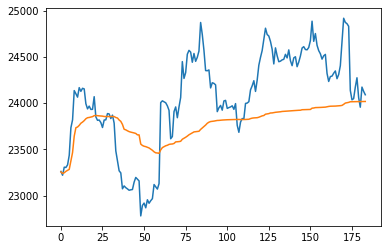

In [ ]:
# Plot Price vs VWAP
plt.subplots()
plt.plot(vwap_df["close"].to_numpy())
plt.plot(vwap_df["vwap"].to_numpy())
plt.show()

### Create Function to Calculate TWAP

The time-weighted average price can be calculated by taking the cumulative sum of averaging the low, close, and high for each price bar and dividing that by the time period (or number of price bars). 

In [ ]:
# Create TWAP function
def twap(dataframe, period):
    tp = (df['low'] + df['close'] + df['high']).divide(3)
    return df.assign(twap=(tp.rolling(period).sum().divide(period)))

twap_df = twap(df, 5)
twap_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2022-08-08 00:00:00+00:00  23180.0  23344.0  23162.0  23261.0   
        2022-08-08 01:00:00+00:00  23273.0  23273.0  23173.0  23220.0   
        2022-08-08 02:00:00+00:00  23220.0  23320.0  23208.0  23307.0   
        2022-08-08 03:00:00+00:00  23309.0  23355.0  23268.0  23304.0   
        2022-08-08 04:00:00+00:00  23309.0  23359.0  23294.0  23332.0   
...                                    ...      ...      ...      ...   
        2022-08-15 11:00:00+00:00  24280.0  24317.0  24014.0  24063.0   
        2022-08-15 12:00:00+00:00  24063.0  24199.0  23916.0  23957.0   
        2022-08-15 13:00:00+00:00  23971.0  24199.0  23945.0  24175.0   
        2022-08-15 14:00:00+00:00  24166.0  24198.0  24064.0  24129.0   
        2022-08-15 15:00:00+00:00  24123.0  24150.0  24062.0  24144.0   

                                    volume  trade_count          vwap  \
symbol  timestamp                                                       
BTC/USD 2022-08-08 00:00:00+00:00  51.6811        262.0  23283.469826   
        2022-08-08 01:00:00+00:00  48.5725        270.0  23197.765102   
        2022-08-08 02:00:00+00:00  23.4935        135.0  23280.354941   
        2022-08-08 03:00:00+00:00  40.7880        168.0  23315.055967   
        2022-08-08 04:00:00+00:00  29.7725        104.0  23341.592634   
...                                    ...          ...           ...   
        2022-08-15 11:00:00+00:00  25.5788       1026.0  24136.715432   
        2022-08-15 12:00:00+00:00  44.3465       1271.0  24052.211322   
        2022-08-15 13:00:00+00:00  43.0791       1143.0  24080.764779   
        2022-08-15 14:00:00+00:00  83.3296        934.0  24131.054656   
        2022-08-15 15:00:00+00:00   2.6523        330.0  24099.031067   

                                           twap  
symbol  timestamp                                
BTC/USD 2022-08-08 00:00:00+00:00           NaN  
        2022-08-08 01:00:00+00:00           NaN  
        2022-08-08 02:00:00+00:00           NaN  
        2022-08-08 03:00:00+00:00           NaN  
        2022-08-08 04:00:00+00:00  23278.666667  
...                                         ...  
        2022-08-15 11:00:00+00:00  24115.533333  
        2022-08-15 12:00:00+00:00  24107.000000  
        2022-08-15 13:00:00+00:00  24126.266667  
        2022-08-15 14:00:00+00:00  24126.333333  
        2022-08-15 15:00:00+00:00  24102.133333  

[184 rows x 8 columns]

### Plot Bitcoin Price and TWAP

Again we can use the new TWAP dataframe calculated in the previous function to visualize the price of Bitcoin as well as it’s TWAP on the same timeframe. 

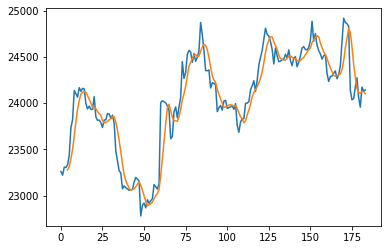

In [ ]:
# Plot Price vs TWAP
plt.subplots()
plt.plot(twap_df["close"].to_numpy())
plt.plot(twap_df["twap"].to_numpy())
plt.show()

### Create Function to Trade Bitcoin via VWAP Strategy

Finally, we can create a function to retrieve the data, calculate the vwap indicator signals, and execute the buy/sell orders. First, the function takes in an input of bar data which is used for the live current close price.

The trend of the vwap shows if buyers or sellers are in control at a particular moment. If the vwap is rising, then buyers are in control and vice versa. If price is above the vwap from a particular start date, then that means the average long participant in the stock is making money. Similarly, if price is below the vwap from a particular start date, then that means the average short participant in the stock from that period is making money.

If the closing price is above the vwap indicator and the vwap is an uptrend, then a buy signal is issued. If the closing price is below the vwap indicator and the vwap is in a downtrend, then a sell signal is issued. So by using the latest values from the dataframe, we can create boolean values for buy and sell signals.

We can set the code to buy 1 quantity of Bitcoin if there is currently no position and if a buy signal is true. Likewise, we can set the code to sell 1 quantity of Bitcoin if there is currently a position and if a sell signal is true.

Wrapping the entire function in a try/except block ensures that the program will not break due to errors, and will simply print out the error message. Since this is a trading bot and is intended to run throughout market hours, it’s best if the program is continuously running.

In [ ]:
# VWAP Indicator Bot Function
def vwap_bot():
    try:
        position = check_positions(symbol=symbol)
        should_buy = vwap_df['close'][-1] > vwap_df["vwap"][-1] and vwap_df["vwap"][-1] > vwap_df["vwap"][-2]
        should_sell = vwap_df['close'][-1] < vwap_df["vwap"][-1] and vwap_df["vwap"][-1] < vwap_df["vwap"][-2]
        print(f"Price: {vwap_df['close'][-1]}")
        print("VWAP: {}".format(vwap_df["vwap"][-1]))
        print(f"Position: {position} | Should Buy: {should_buy}")

        # Check if No Position and Buy Signal is True
        if position == 0 and should_buy == True:
            # preparing orders
            market_order_data = MarketOrderRequest(
                                symbol=symbol,
                                qty=qty_per_trade,
                                side=OrderSide.BUY,
                                time_in_force=TimeInForce.GTC
                                )

            # Market order
            market_order = trading_client.submit_order(
                            order_data=market_order_data
                          )
            message = f'Symbol: {symbol} | Side: Buy | Quantity: {qty_per_trade}'
            print(message)

        # Check if Long Position and Sell Signal is True
        elif position > 0 and should_sell == True:
            # preparing orders
            market_order_data = MarketOrderRequest(
                                symbol=symbol,
                                qty=qty_per_trade,
                                side=OrderSide.Sell,
                                time_in_force=TimeInForce.GTC
                                )

            # Market order
            market_order = trading_client.submit_order(
                            order_data=market_order_data
                          )
            message = f'Symbol: {symbol} | Side: Sell | Quantity: {qty_per_trade}'
            print(message)
        print("-"*20)

    except Exception as e:
        print (e)

### Set Up Alpaca Live Crypto Data

The last step of building the Python bot is to start streaming live market data for Bitcoin from Alpaca. Fortunately, Alpaca makes this process extremely easy. 

First, we have to create an instance of the data streaming API by calling the CryptoDataStream method in which we pass the API keys. Then, we can create an asynchronous function to receive the live bar data and within this function, we can call the vwap_bot function.

Here, we can subscribe to crypto data, and start streaming live data!

In [ ]:
crypto_stream = CryptoDataStream(API_KEY, SECRET_KEY)

# async handler
async def quote_data_handler(data):
    print(data)
    vwap_bot()

crypto_stream.subscribe_quotes(quote_data_handler, "BTCUSD")
crypto_stream.run()

## Conclusion

In this tutorial, we covered everything from using historical data to calculate the volume-weighted average price and time-weighted average price to executing live orders in alpaca’s paper trading account. To access and run the code from this article in a Google Colab Notebook, check out this link!

Thanks for reading, and I hope you learned something about using the VWAP and TWAP with the alpaca-py Python SDK!
